# Wine Quality

## This notebook is used to create a predictive model to classify wine as good or bad.

In [1]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_e62b6c1bb76c4710b1d1cc5aeab9a929 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='BSb8cwQzAQWwQDYH_tzBK00I2y9L6MiAHkOrru00uzdY',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_e62b6c1bb76c4710b1d1cc5aeab9a929.get_object(Bucket='winequality-donotdelete-pr-g670fqfs5w9dum',Key='winequality-red.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()


,Index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,2,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [2]:
! pip install seaborn --upgrade

     |████████████████████████████████| 285 kB 14.8 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1


### Loading the packages

In [3]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
import seaborn as sns; sns.set_theme(style = "dark")
%matplotlib inline
import matplotlib.pyplot as plt

### Data Visualization

In [4]:
wine = df_data_1

In [5]:
wine.drop("Index", axis = 1, inplace = True)

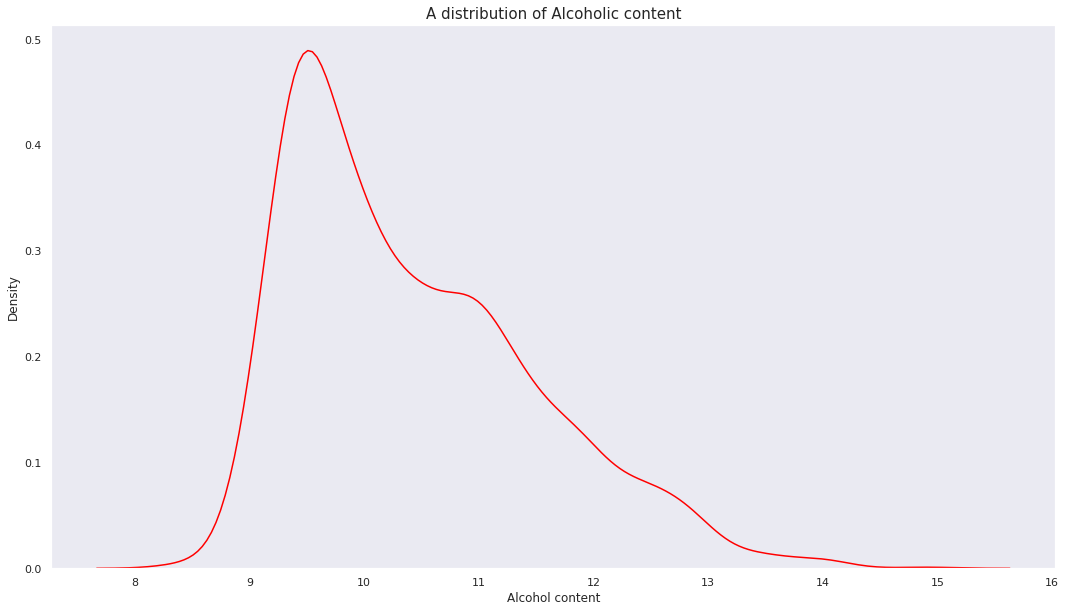

In [6]:
plt.figure(figsize = (18,10))
sns.kdeplot(x = "alcohol", data = wine, color = "red")
plt.xlabel("Alcohol content")
plt.ylabel("Density")
plt.title("A distribution of Alcoholic content", fontsize = 15)
plt.show();

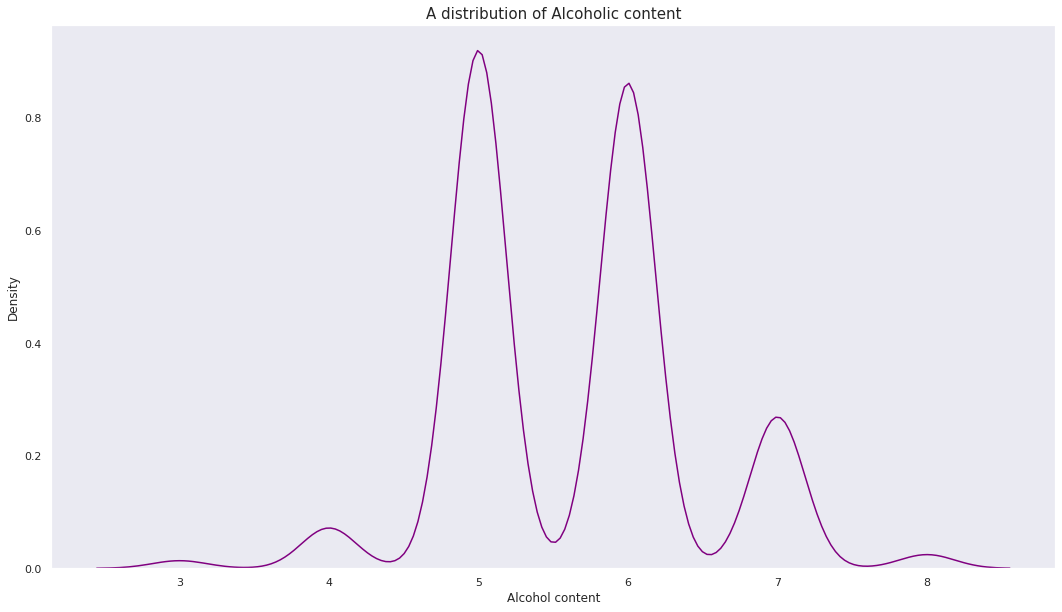

In [7]:
plt.figure(figsize = (18,10))
sns.kdeplot(x = "quality", data = wine, color = "purple")
plt.xlabel("Alcohol content")
plt.ylabel("Density")
plt.title("A distribution of Alcoholic content", fontsize = 15)
plt.show();

### Building Predictive Model

In [8]:
x_wine = wine.iloc[:,:-1]
y_wine = wine.iloc[:,-1]
y_wine_bi = (y_wine >= 7).astype(int)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_wine, y_wine_bi, train_size = 0.8, random_state = 42)

In [10]:
cor = wine.corr()

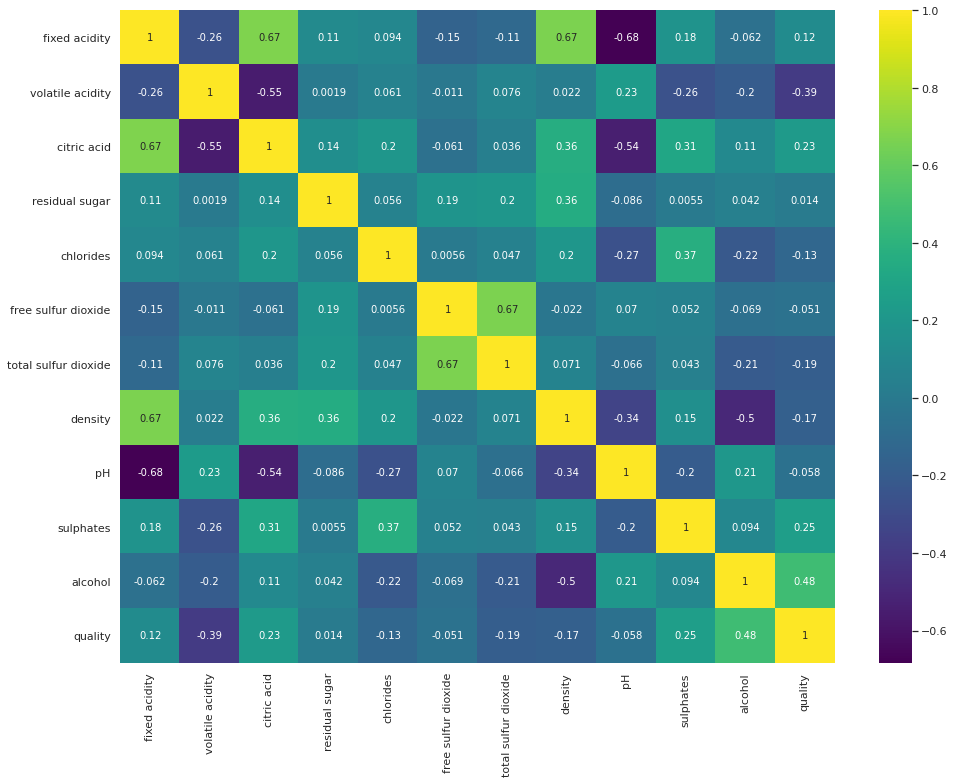

In [11]:
plt.figure(figsize = (16,12))
sns.heatmap(cor, annot = True, cmap = "viridis")
plt.show();

#### Decision Tree

In [12]:
clf = DecisionTreeClassifier(max_depth = 4, max_features = 6)
x_train_new = x_train[["volatile acidity", "citric acid", "chlorides", "pH", "sulphates", "alcohol"]]
clf.fit(x_train_new, y_train);

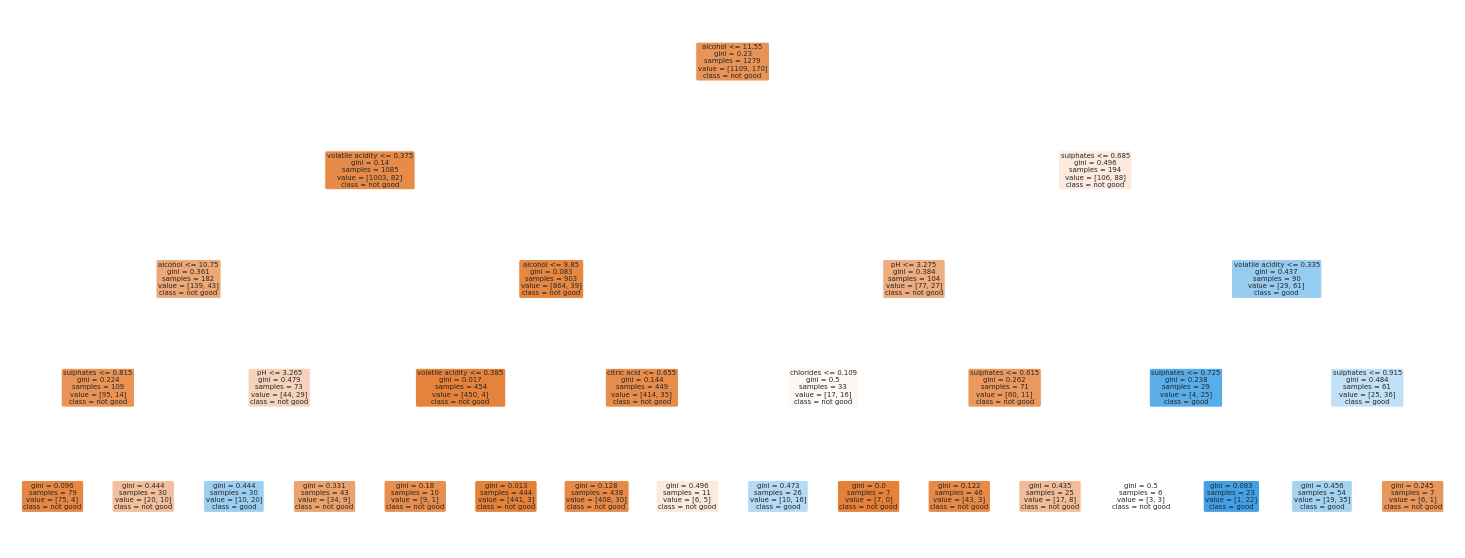

In [13]:
plt.figure(figsize = (26,10))
tree.plot_tree(clf,
               feature_names = ["volatile acidity", "citric acid", "chlorides", "pH", "sulphates", "alcohol"],
               class_names = ["not good","good"],
               rounded = True,
               filled = True
              );

In [14]:
x_test_new = x_test[["volatile acidity", "citric acid", "chlorides", "pH", "sulphates", "alcohol"]]
clf.score(x_test_new, y_test)

0.871875

In [15]:
! pip install pydotplus

     |████████████████████████████████| 278 kB 15.4 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=ee9fdd7fe90faddb3090649865bbd503a405084fcfcdc1146c748ad4f7389eb8
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


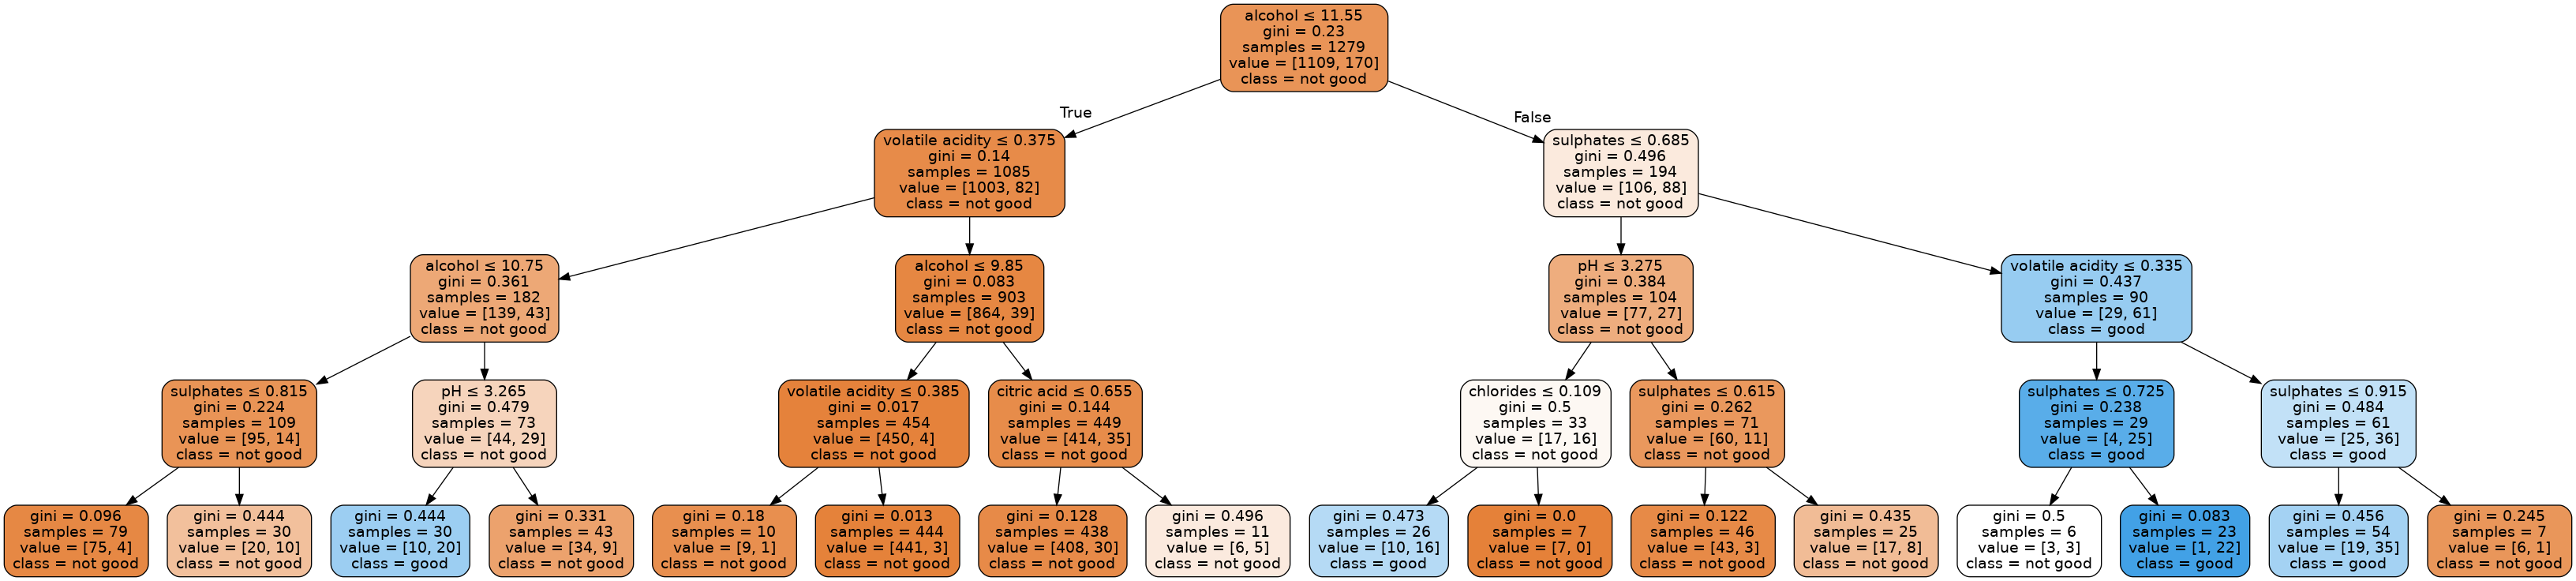

In [16]:
import pydotplus
from IPython.display import Image 
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names= x_train_new.columns,
                         class_names = ["not good", "good"],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### Random Forest Classifier

In [18]:
pipeline = Pipeline([("rfe", RFECV(Ridge(alpha = 1.0,solver = "cholesky"), cv = 5)), ("trees", RandomForestClassifier(max_features = 5, max_depth = 10, n_estimators = 19))])

In [19]:
final_model = pipeline

In [20]:
final_model.fit(x_train, y_train)

Pipeline(steps=[('rfe', RFECV(cv=5, estimator=Ridge(solver='cholesky'))),
                ('trees',
                 RandomForestClassifier(max_depth=10, max_features=5,
                                        n_estimators=19))])

In [21]:
final_model["trees"].feature_importances_

array([0.15219148, 0.13118636, 0.13182435, 0.11763015, 0.18359658,
       0.28357108])

In [22]:
final_model["rfe"].ranking_
feature = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 
           'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']
feature_rank = pd.DataFrame({"feature":feature, "rank":final_model["rfe"].ranking_})
feature_rank

,feature,rank
0,fixed acidity,3
1,volatile acidity,1
2,citric acid,1
3,residual sugar,4
4,chlorides,1
5,free sulfur dioxide,6
6,total sulfur dioxide,5
7,density,2
8,pH,1
9,sulphates,1


#### Metrics

In [23]:
y_train_pred = cross_val_predict(final_model, x_train, y_train, cv = 5)

In [24]:
new_train = x_train.copy()
new_train["quality"] = y_train
new_train["predicted quality"] = y_train_pred
new_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,predicted quality
493,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6,0,0
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9,0,1
342,10.9,0.390,0.47,1.8,0.118,6.0,14.0,0.99820,3.30,0.75,9.8,0,0
834,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4,0,0
705,8.4,1.035,0.15,6.0,0.073,11.0,54.0,0.99900,3.37,0.49,9.9,0,0


In [25]:
precision_score(y_train, y_train_pred)

0.672

In [26]:
recall_score(y_train, y_train_pred)

0.49411764705882355

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_train_pred)

0.9007036747458952

In [28]:
f1_score(y_train, y_train_pred)

0.5694915254237288

In [29]:
conf = confusion_matrix(y_train, y_train_pred)

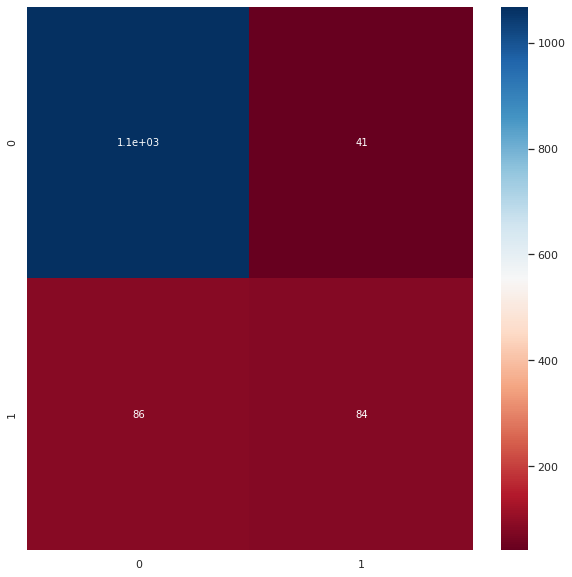

In [30]:
plt.figure(figsize = (10,10))
sns.heatmap(conf, annot= True, cmap = "RdBu")
plt.show();

In [31]:
cross_val_score(final_model, x_train, y_train, cv = 5)

array([0.85546875, 0.87890625, 0.8671875 , 0.9140625 , 0.91764706])

In [32]:
precisions, recall, threshold = precision_recall_curve(y_train, y_train_pred)

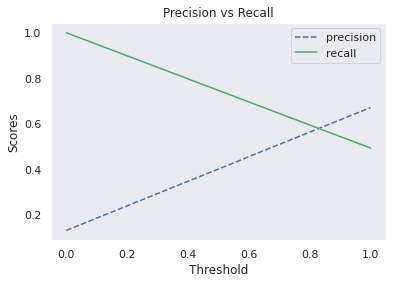

In [33]:
sns.set_theme(style="dark")
##plt.figure(figsize = (20,8))
plt.plot(threshold, precisions[:-1],'b--',label = "precision")
plt.plot(threshold, recall[:-1], 'g-', label = "recall")
plt.title("Precision vs Recall")
plt.xlabel("Threshold")
plt.ylabel("Scores")
plt.legend()
plt.show();

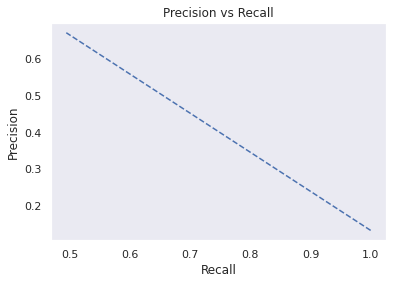

In [34]:
##plt.figure(figsize = (20,8))
plt.plot(recall[:-1], precisions[:-1], 'b--')
plt.title("Precision vs Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show();

In [35]:
fpr, tpr, threshold = roc_curve(y_train, y_train_pred)

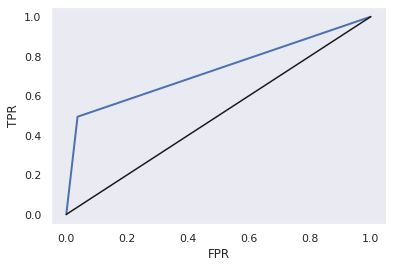

In [36]:
##plt.figure(figsize = (20,8))
plt.plot(fpr, tpr, "b-", linewidth = 2)
plt.plot([0,1], [0,1], "k-")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show();

In [37]:
roc_auc_score(y_train, y_train_pred)

0.7285737017981223

In [38]:
y_pred = final_model.predict(x_test)

In [39]:
precision_score(y_test, y_pred)

0.6829268292682927

In [40]:
recall_score(y_test, y_pred)

0.5957446808510638

In [41]:
accuracy_score(y_test, y_pred)

0.9

In [42]:
f1_score(y_test, y_pred)

0.6363636363636364

In [43]:
roc_auc_score(y_test, y_pred)

0.7740628166160081

In [44]:
fpr2, tpr2, threshold2 = roc_curve(y_test, y_pred)

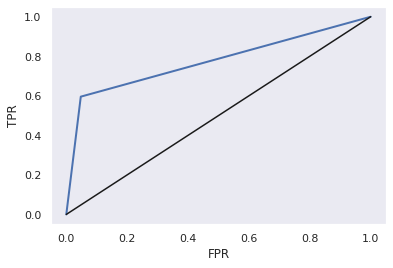

In [45]:
plt.plot(fpr2, tpr2, "b-", linewidth = 2)
plt.plot([0,1], [0,1], "k-")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show();